# TSIA202b - Practical work on spectral estimation 

## Rayane Dakhlaoui et Adam Chgour

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, lfilter, periodogram
import librosa as lb
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import os
import pyaudio
import scipy.io.wavfile
from IPython.display import Audio
import wave
import math
import sys 
import struct

In [3]:
N = 1024
sigma2 = 1
noise_std = np.sqrt(sigma2)
fs = 1

Remarque: Il faut s'assurer que le filtre est causale, stable

## 1. Autoregressive process
### 1.1 Synthesis

<u>Question 1:</u>

In [4]:
def generate_AR(coeff, n_samples, noise_std=1.0, burnin=100):
    p = len(coeff)
    series = np.zeros(n_samples + burnin)
    noise = np.random.normal(0, noise_std, n_samples + burnin)
    for t in range(p, n_samples + burnin):
        series[t] = sum(coeff[i] * series[t - i - 1] for i in range(p)) + noise[t]
    return series[burnin:]

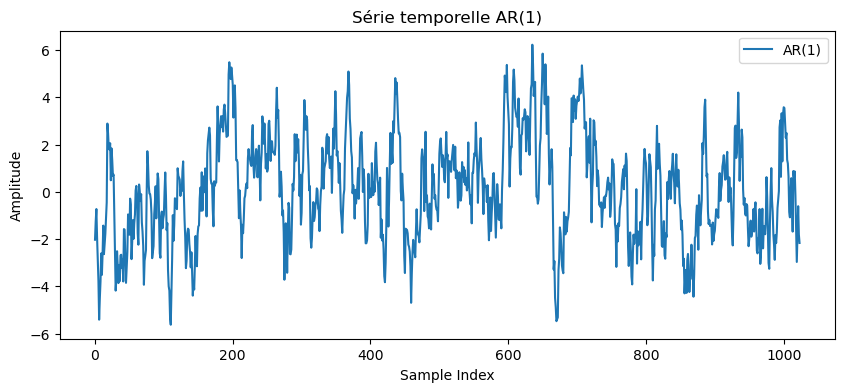

In [5]:
# Coefficients du modèle AR1
ar_coeff = [0.9]
x = generate_AR(ar_coeff, N, noise_std)

plt.figure(figsize=(10, 4))
plt.plot(x, label = 'AR(1)')
plt.title('Série temporelle AR(1)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 1.2 Non-parametric estimation : periodogram

<u>Question 2:</u>

In [6]:
def computes_periodogram (signal, fs, method, n_segments=None):
    if method == 'standard':
        freqs, psd = periodogram(signal, fs=fs)
    elif method in ['bartlett', 'welch']:
        if n_segments is None:
            raise ValueError("n_segments must be specified for Bartlett or Welch methods.")
        if method == 'bartlett':
            freqs, psd = welch(x, fs=1.0, nperseg=256, window='boxcar', noverlap=128, nfft=512)
        else:
            freqs, psd = welch(x, fs=1.0, nperseg=256, noverlap=128, nfft=512)
    else:
        raise ValueError("Invalid method. Choose 'standard', 'bartlett', or 'welch'.")
    return freqs, psd


def visualisation(f, Pxx, method: {'standard', 'bartlett', 'welch'}, psd):
    f = np.fft.fftshift(f)
    Pxx = np.fft.fftshift(Pxx)
    psd = np.fft.fftshift(psd)
    
    #computation of the bias and variance of each estimator
    bias = np.mean(Pxx - psd)
    variance = np.var(Pxx)
    print("the bias of the", method, "estimator is:", bias,"and its variance is", variance)
    
    plt.figure(figsize=(10, 6))
    plt.plot(f, 10*np.log10(psd), color='blue', label="PSD")
    plt.plot(f, 10*np.log10(Pxx), color='red', alpha = 0.5, label=method)
    plt.xlabel('Normalized frequency')
    plt.ylabel('Power Spectral Density (dB)')
    if (method == 'Std'):
        plt.title('Periodogram computed using the standard method')
    elif (method == 'B'):
        plt.title('Periodogram computed using the Barlett method')
    elif (method == 'W'):
        plt.title('Periodogram computed using the Welch method')
    plt.grid(True)
    plt.legend()
    plt.show()

<u>Question 3:</u>

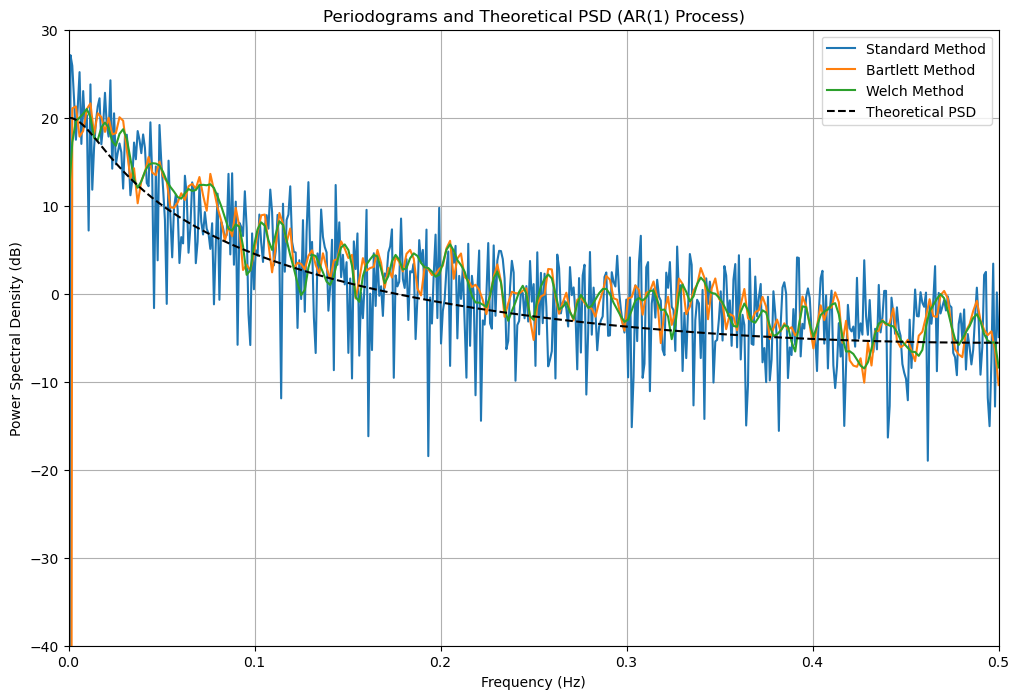

In [7]:
def theoretical_psd_ar1(ar_coeff, sigma2, fs, n_points=513):
    freqs = np.linspace(-fs / 2, fs / 2, n_points)  
    w = 2 * np.pi * freqs / fs  
    psd = sigma2 / (np.abs(1 - ar_coeff * np.exp(-1j * w))**2)
    return freqs, psd

# AR(1) proc. parameters
fs = 1.0
ar_coeffs = [0.9]  
sigma2 = 1.0   
x_ar1 = generate_AR(ar_coeffs, N, noise_std)

# Theoretical PSD
freqs_theoretical, psd_theoretical = theoretical_psd_ar1(ar_coeff, sigma2, fs, n_points=513)

# Periodograms (dB)
methods = ['standard', 'bartlett', 'welch']
n_segments = 8  

plt.figure(figsize=(12, 8))
for method in methods:
    if method == 'standard':
        freqs, psd = periodogram(x_ar1, fs)
    else:
        freqs, psd = computes_periodogram(x_ar1, fs, method, n_segments)
    psd_db = 10 * np.log10(psd)
    plt.plot(freqs, psd_db, label=f"{method.capitalize()} Method")

psd_theoretical_db = 10 * np.log10(psd_theoretical)
plt.plot(freqs_theoretical, psd_theoretical_db, 'k--', label="Theoretical PSD")

plt.title("Periodograms and Theoretical PSD (AR(1) Process)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.legend()
plt.xlim(0, 0.5)
plt.ylim(-40, 30)
plt.grid()
plt.show()

<u>Question 4:</u>

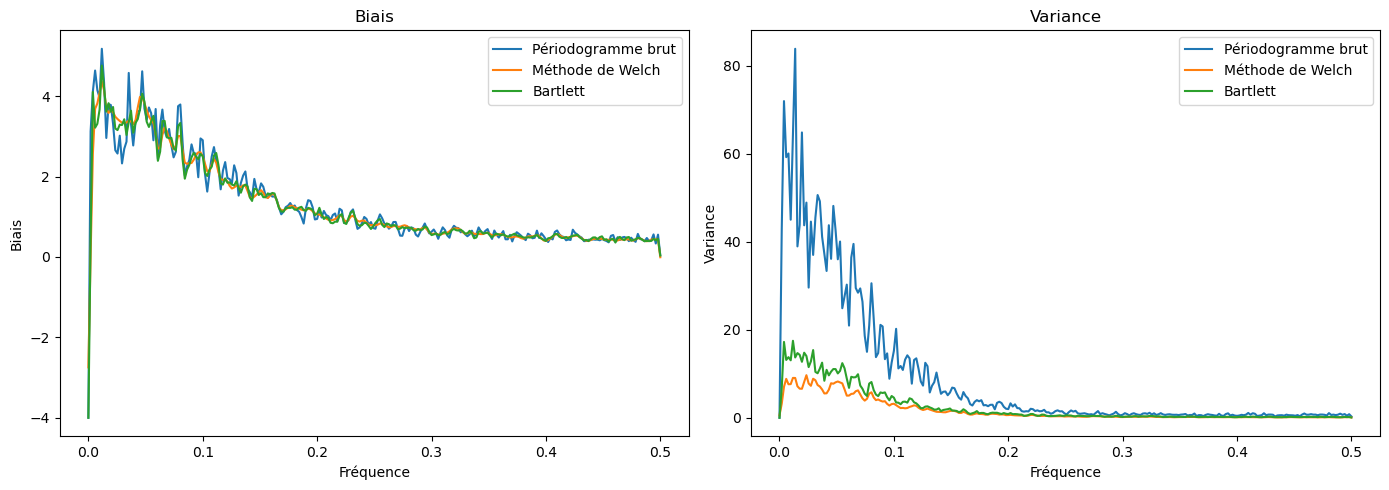

                   Biais moyen Variance moyenne
Périodogramme brut    1.360423         8.993309
Méthode de Welch      1.314609         1.649797
Bartlett              1.318025         2.525304


In [8]:
def AR_theoretical_spectrum(coeff, frequencies):
    p = len(coeff)
    z = np.exp(-2j * np.pi * frequencies)
    denominator = np.ones_like(frequencies, dtype=complex)
    for i in range(p):
        denominator -= coeff[i] * z**(i+1)
    return 1.0 / np.abs(denominator)**2

def compare_estimators(ar_coeff, n_samples=1000, n_realizations=100, noise_std=1.0):
    frequencies = np.linspace(0, 0.5, 256)
    theoretical_spectrum = AR_theoretical_spectrum(ar_coeff, frequencies)
    raw_periodograms = np.zeros((n_realizations, len(frequencies)))
    welch_periodograms = np.zeros((n_realizations, len(frequencies)))
    bartlett_periodograms = np.zeros((n_realizations, len(frequencies)))

    for i in range(n_realizations):
        x = generate_AR(ar_coeff, N, noise_std)
        f_raw, pxx_raw = periodogram(x, fs=1.0, nfft=512)
        raw_periodograms[i] = np.interp(frequencies, f_raw, pxx_raw)
        f_welch, pxx_welch = welch(x, fs=1.0, nperseg=256, noverlap=128, nfft=512)
        welch_periodograms[i] = np.interp(frequencies, f_welch, pxx_welch)
        n_segments = 4
        segment_len = n_samples // n_segments
        bartlett_pxx = np.zeros_like(f_raw)
        for j in range(n_segments):
            start_idx = j * segment_len
            end_idx = (j + 1) * segment_len
            segment = x[start_idx:end_idx]
            _, pxx_segment = periodogram(segment, fs=1.0, nfft=512)
            bartlett_pxx += pxx_segment
        bartlett_pxx /= n_segments
        bartlett_periodograms[i] = np.interp(frequencies, f_raw, bartlett_pxx)

    estimators = {
        'Périodogramme brut': raw_periodograms,
        'Méthode de Welch': welch_periodograms,
        'Bartlett': bartlett_periodograms,
    }

    results = {}
    for name, data in estimators.items():
        mean_spectrum = np.mean(data, axis=0)
        bias = mean_spectrum - theoretical_spectrum
        variance = np.var(data, axis=0)
        results[name] = {'bias': bias, 'variance': variance}

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for name, data in results.items():
        axs[0].plot(frequencies, data['bias'], label=name)
    axs[0].set_title('Biais')
    axs[0].set_xlabel('Fréquence')
    axs[0].set_ylabel('Biais')
    axs[0].legend()

    for name, data in results.items():
        axs[1].plot(frequencies, data['variance'], label=name)
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Fréquence')
    axs[1].set_ylabel('Variance')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    metrics = pd.DataFrame(index=estimators.keys(), columns=['Biais moyen', 'Variance moyenne'])
    for name, data in results.items():
        metrics.loc[name, 'Biais moyen'] = np.mean(np.abs(data['bias']))
        metrics.loc[name, 'Variance moyenne'] = np.mean(data['variance'])

    return metrics

ar_coeff = [0.5]
results = compare_estimators(ar_coeff, n_samples=1000, n_realizations=100)
print(results)


<u>Question 5:</u>

In [9]:
def estimate_AR_lpc(series, order):
    ar_coeffs = lb.lpc(series, order =order)
    return ar_coeffs

<u>Question 6:</u>

Coefficient AR vrai: 0.9
Coefficient AR estimé: 0.911314893216664


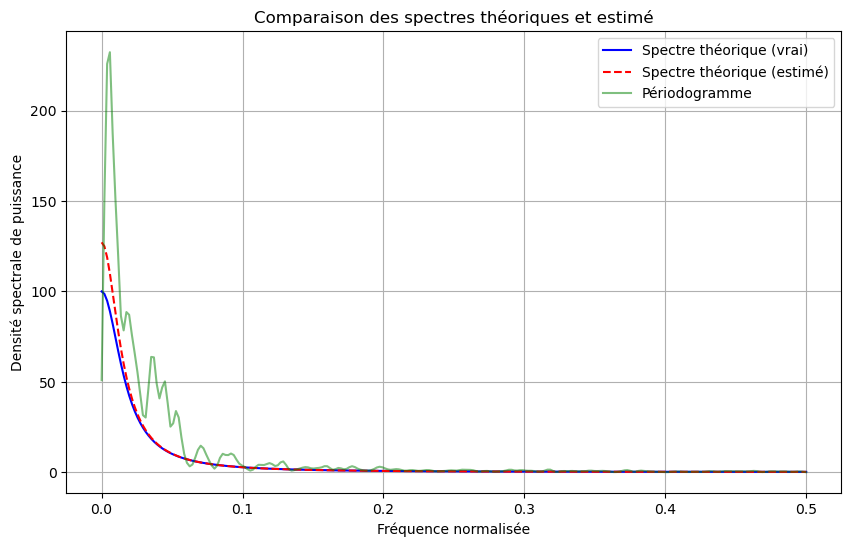

Erreur d'estimation: 0.011315
MSE entre les spectres: 12.530506


In [10]:
true_coeff = [0.9]
n_samples = 1000
x = generate_AR(true_coeff, n_samples)

ar_order = 1
estimated_coeffs = -estimate_AR_lpc(x, ar_order)[1:]

print(f"Coefficient AR vrai: {true_coeff[0]}")
print(f"Coefficient AR estimé: {estimated_coeffs[0]}")

frequencies = np.linspace(0, 0.5, 256)
true_spectrum = AR_theoretical_spectrum(true_coeff, frequencies)
estimated_spectrum = AR_theoretical_spectrum(estimated_coeffs, frequencies)

plt.figure(figsize=(10, 6))
plt.plot(frequencies, true_spectrum, 'b-', label='Spectre théorique (vrai)')
plt.plot(frequencies, estimated_spectrum, 'r--', label='Spectre théorique (estimé)')

f, pxx = welch(x, fs=1.0, nfft=512)
plt.plot(f, pxx, 'g-', alpha=0.5, label='Périodogramme')

plt.xlabel('Fréquence normalisée')
plt.ylabel('Densité spectrale de puissance')
plt.title('Comparaison des spectres théoriques et estimé')
plt.legend()
plt.grid(True)
plt.show()

error = np.abs(true_coeff[0] - estimated_coeffs[0])
print(f"Erreur d'estimation: {error:.6f}")

mse = np.mean((true_spectrum - estimated_spectrum)**2)
print(f"MSE entre les spectres: {mse:.6f}")


Commentaire: 

<u>Question 7:</u>

In [11]:

audio_file_path = r'/Users/rayanedakhlaoui/Desktop/TSIA202b/sounds/aeiou.wav'
audio_signal, sample_rate = lb.load(audio_file_path, sr=None)

print("Forme du signal :", audio_signal.shape)
print("Taux d'échantillonnage :", sample_rate)

plt.plot(audio_signal)
plt.title("voyel 'a'")
plt.show()

/var/folders/21/2t2dfjlx0_9046yb33sx1py00000gn/T/ipykernel_91711/4156307011.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sample_rate = lb.load(audio_file_path, sr=None)
/Users/adamchgour/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rayanedakhlaoui/Desktop/TSIA202b/sounds/aeiou.wav'

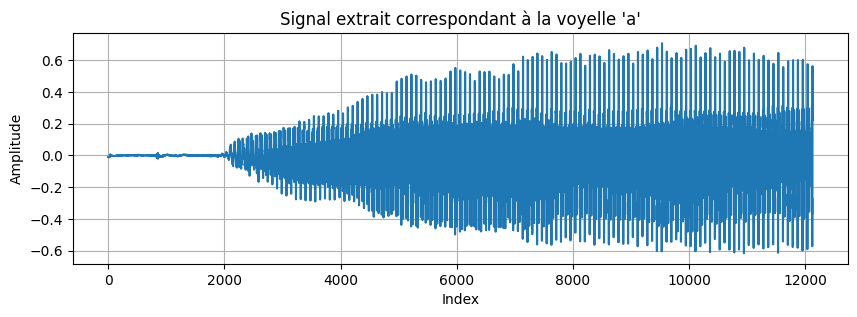

In [ ]:
duration = 1.1 
samples = int(sample_rate * duration)
vowel_a = audio_signal[:samples]

plt.figure(figsize=(10, 3))
plt.plot(vowel_a)
plt.title("Signal extrait correspondant à la voyelle 'a'")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

Audio(vowel_a, rate=sample_rate)


In [13]:
def periodogram_(X, method: {'Std', 'B', 'W'}):
    N = len(X) #len of the samples
    
    #Barlett method
    M = int(np.sqrt(N)) #size of the sub_samples
    L = N // M #nb of sub_samples
    f = [] 
  
    #Welch method
    K = M // 2
    S = 2 * N // M - 1

    if (method == 'Std'):

         f, Pxx = np.fft.fftfreq(N), 1/N * np.abs(np.fft.fft(X))**2

    elif method == 'B':

        f =  np.fft.fftfreq(N)
        Pxx = np.zeros_like(f)
        for i in range(L): #on effectue L fft of samples of size M 
            Pxx_int = 1/(L*M) * np.abs(np.fft.fft(X[i*M:(i + 1)*M], n=N))**2
            Pxx = Pxx + Pxx_int       
 
    elif method == 'W':
        P = np.sum(np.hamming(M)**2) / M
        f =  np.fft.fftfreq(N)
        Pxx = np.zeros_like(f)
        for i in range(S): #on effectue S fft of samples of size M
            Pxx +=  np.abs(np.fft.fft(X[i*K:i*K + M] * np.hanning(M), n=N)**2) / (M*P*S)
                   
    return f, Pxx

for i in({'Std', 'B', 'W'}):
    f_w, Pxx = periodogram_(audio_signal, method=i)
    f_w = np.fft.fftshift(f_w)
    Pxx = np.fft.fftshift(Pxx)
    if (i=='Std'):
        plt.plot(f_w, Pxx, color='blue', label="Standard")
    elif (i=='W'):
        plt.plot(f_w, Pxx, color='green', label="Welch")
    elif (i=='B'):
        plt.plot(f_w, Pxx, color='red', label="Barlett")

plt.title("Periodogram of the letter 'a'")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
plt.legend()
plt.show()

NameError: name 'audio_signal' is not defined

## 2. Sum of noisy sinusoids

<u>Question 1:</u>

In [14]:
def generate_sum_sine(nu, N, K,noise_std = noise_std):
    series = np.zeros(N)
    noise = np.random.normal(0, noise_std, N)
    
    for k in range(0,K):
        series += np.sin(2 * np.pi * nu[k] * np.arange(N) / N)
    
    return series + noise

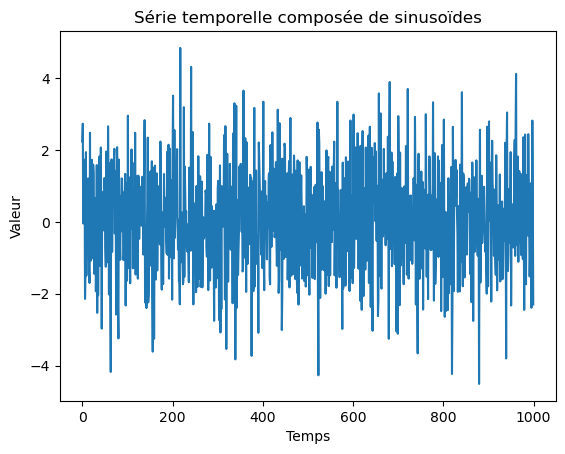

In [15]:
nu = [250,300]
series = generate_sum_sine(nu,N=1000, K=2)
plt.plot(series)
plt.title("Série temporelle composée de sinusoïdes")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.show()

<u>Question 2:</u>

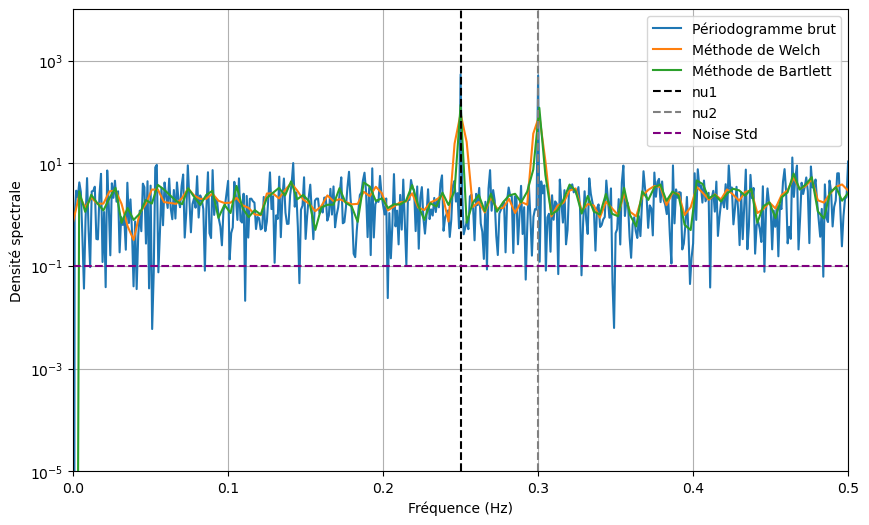

In [16]:
plt.figure(figsize=(10, 6))
plt.semilogy(periodogram(series, fs=1.0)[0], periodogram(series, fs=1.0)[1])
plt.semilogy(welch(series, fs=1.0, nperseg=256)[0], welch(series, fs=1.0, nperseg=256)[1])
plt.semilogy(welch(series, fs=1.0, nperseg=256, window='boxcar')[0], welch(series, fs=1.0, nperseg=256, window='boxcar')[1])
plt.axvline(x= nu[0]/ 1000, color='k', linestyle='--', label='nu1')
plt.axvline(x= nu[1] / 1000, color='gray', linestyle='--', label='nu2')
plt.axhline(y=0.1, color='purple', linestyle='--', label='Noise Std')
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale")
plt.legend(["Périodogramme brut", "Méthode de Welch", "Méthode de Bartlett", "nu1", "nu2", "Noise Std"])
plt.xlim(0, 0.5)
plt.ylim(1e-5, 1e4)
plt.grid()
plt.show()

En faisant varier les valeurs de nu1 et nu2, on se rend compte qu'à partir d'un écart de 0.04 en fréquence réduite, les deux pics commencent à se rejoindre pour la méthode de Barlett, contrairement à celle de Welch qui permet de bien distinguer les pics jusqu'à 0.02 d'écart environ

In [17]:
SNR = max(np.abs(series)) / np.std(series)
print(f"SNR: {SNR:.2f} dB")

SNR: 3.36 dB


<u>Question 4:</u>

In [18]:
def estimate_AR_yule_walker(series, order):
    model = AutoReg(series, lags=order)
    model_fit = model.fit()
    ar_coeffs = model_fit.params[1:]
    
    return ar_coeffs

coeffs = estimate_AR_yule_walker(series, 4)
AR4 = generate_AR(coeffs, 1000)

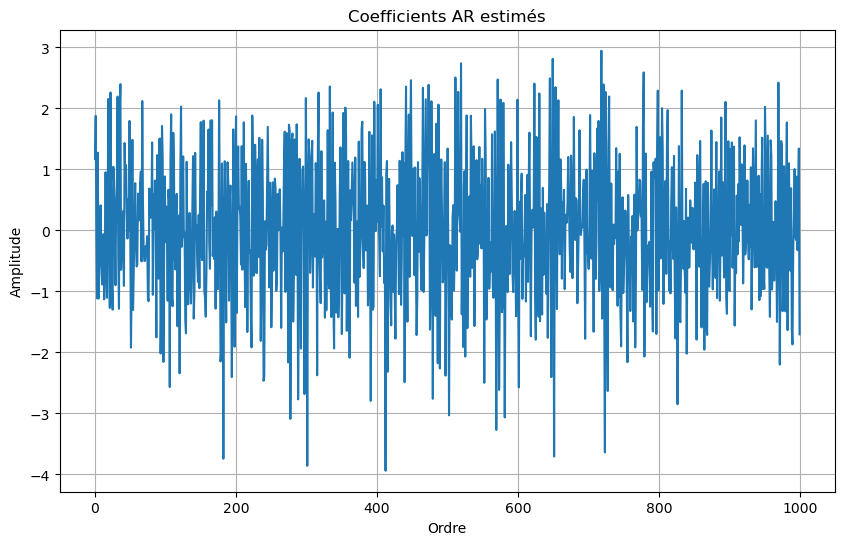

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(AR4)
plt.title("Coefficients AR estimés")
plt.xlabel("Ordre")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

<u>Question 5:</u>

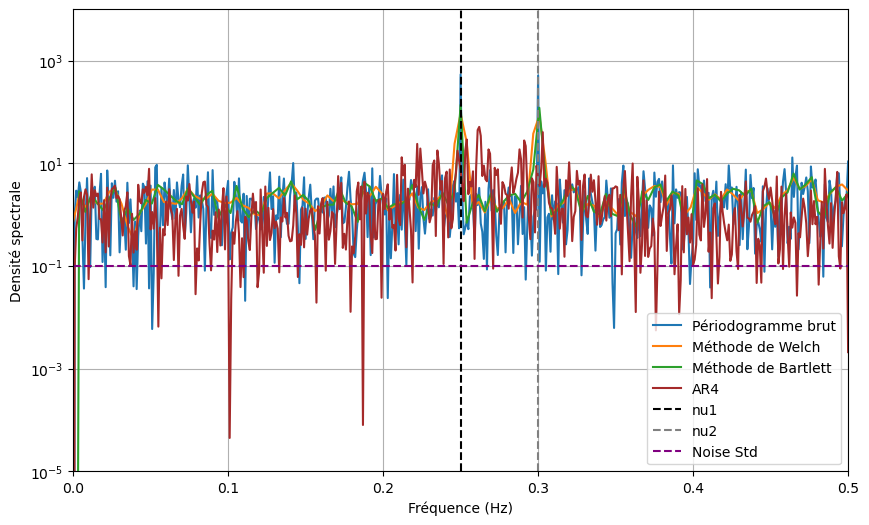

In [20]:
plt.figure(figsize=(10, 6))
plt.semilogy(abs(periodogram(series, fs=1.0)[0]), periodogram(series, fs=1.0)[1])
plt.semilogy(abs(welch(series, fs=1.0, nperseg=256)[0]), welch(series, fs=1.0, nperseg=256)[1])
plt.semilogy(abs(welch(series, fs=1.0, nperseg=256, window='boxcar')[0]), welch(series, fs=1.0, nperseg=256, window='boxcar')[1])
plt.semilogy(periodogram(AR4, fs=1.0)[0],periodogram(AR4,fs=1.0)[1], 'brown', label="Spectre théorique")
plt.axvline(x=nu[0] / 1000, color='k', linestyle='--', label='nu1')
plt.axvline(x=nu[1] / 1000, color='gray', linestyle='--', label='nu2')
plt.axhline(y=0.1, color='purple', linestyle='--', label='Noise Std')
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale")
plt.legend(["Périodogramme brut", "Méthode de Welch", "Méthode de Bartlett","AR4", "nu1", "nu2", "Noise Std"])
plt.xlim(0, 0.5)
plt.ylim(1e-5, 1e4)
plt.grid()
plt.show()

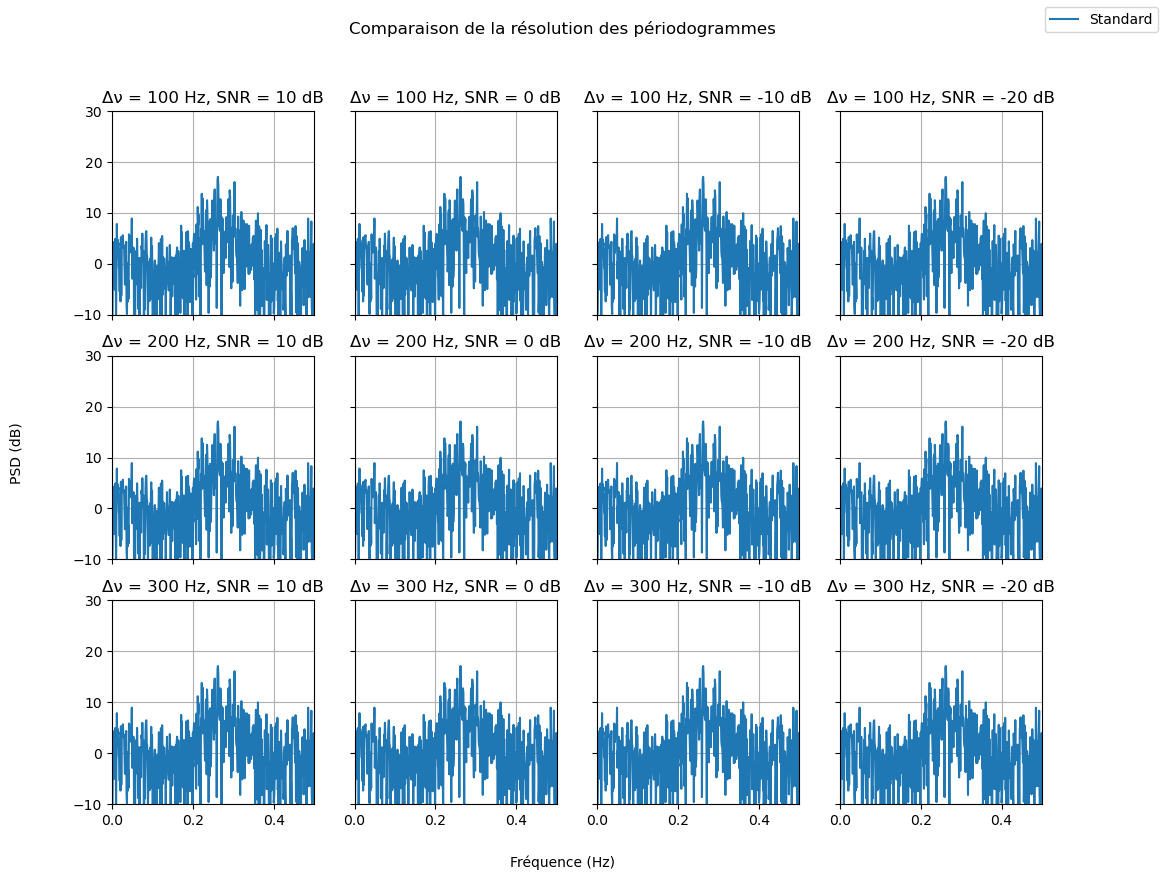

In [43]:
def computes_periodogram(signal, fs=1.0, method='standard', n_segments=None):
    if method == 'standard':
        freqs, psd = periodogram(signal, fs=fs)
    elif method in ['bartlett', 'welch']:
        if n_segments is None:
            raise ValueError("n_segments must be specified for Bartlett or Welch methods.")
        segment_length = len(signal) // n_segments
        if method == 'bartlett':
            freqs, psd = welch(signal, fs=fs, nperseg=segment_length, window='boxcar')
        else:
            freqs, psd = welch(signal, fs=fs, nperseg=segment_length)
    else:
        raise ValueError("Invalid method. Choose 'standard', 'bartlett', or 'welch'.")
    return freqs, psd


N = 1024
amplitudes = [1.0, 1.0]
phases = [0, 0]


delta_nus = [100, 200, 300]   
snr_values = [10, 0, -10, -20]   

methods = ['standard']
n_segments = 256  

fig, axs = plt.subplots(len(delta_nus), len(snr_values), figsize=(12, 9), sharex=True, sharey=True)

for i, delta_nu in enumerate(delta_nus):
    for j, snr_db in enumerate(snr_values):
        frequencies = [100, 100 + delta_nu]

        signal_power = np.mean(np.array(amplitudes)**2) / 2  
        noise_power = signal_power / (10**(snr_db / 10))     
        sigma2 = noise_power

        s = generate_sum_sine(frequencies, N, K=2, noise_std=np.sqrt(sigma2))

        axs[i, j].set_title(f"Δν = {delta_nu} Hz, SNR = {snr_db} dB")
        for method in methods:
            freqs, psd = computes_periodogram(AR4, fs=1.0, method=method, n_segments=n_segments)
            axs[i, j].plot(freqs, 10 * np.log10(psd), label=f"{method.capitalize()}")

        for freq in frequencies:
            axs[i, j].axvline(x=freq, color='grey', linestyle='--')

        axs[i, j].set_ylim(-10, 30)
        axs[i, j].set_xlim(0, 0.5)
        axs[i, j].grid()

# Légende et labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.text(0.5, 0.04, "Fréquence (Hz)", ha='center')
fig.text(0.04, 0.5, "PSD (dB)", va='center', rotation='vertical')
plt.suptitle("Comparaison de la résolution des périodogrammes")
plt.show()

<u>Question 6:</u>

In [21]:
def capon_method(signal, fs=1.0, num_freqs=512, order=100):
    """
    Estimates the power spectrum of a signal using the Capon method (MVDR).
    
    Parameters:
        signal (np.ndarray): Input signal.
        fs (float): Sampling frequency.
        num_freqs (int): Number of frequency points.
        order (int): Model order (size of correlation matrix).
    
    Returns:
        freqs (np.ndarray): Frequencies.
        spectrum (np.ndarray): Estimated power spectrum.
    """
    signal = np.asarray(signal)
    n = len(signal)
     
    # Create data matrix (each row is a segment)
    X = np.zeros((n - order + 1, order))
    for i in range(n - order + 1):
        X[i, :] = signal[i:i+order]
    
    # Calculate covariance matrix
    R = np.dot(X.T, X) / (n - order + 1)
    
    # Add regularization
    R += np.eye(order) * np.trace(R) * 1e-6
    
    # Invert the matrix
    try:
        R_inv = np.linalg.inv(R)
    except np.linalg.LinAlgError:
        R_inv = np.linalg.pinv(R)
    
    # Calculate spectrum
    freqs = np.linspace(0, fs/2, num_freqs)
    spectrum = np.zeros(num_freqs)
    
    # Calculate spectrum for each frequency
    for i, freq in enumerate(freqs):
        # Steering vector
        e = np.exp(-2j * np.pi * freq / fs * np.arange(order))
        spectrum[i] = order / np.real(np.dot(np.conj(e), np.dot(R_inv, e)))
    
    return freqs, spectrum

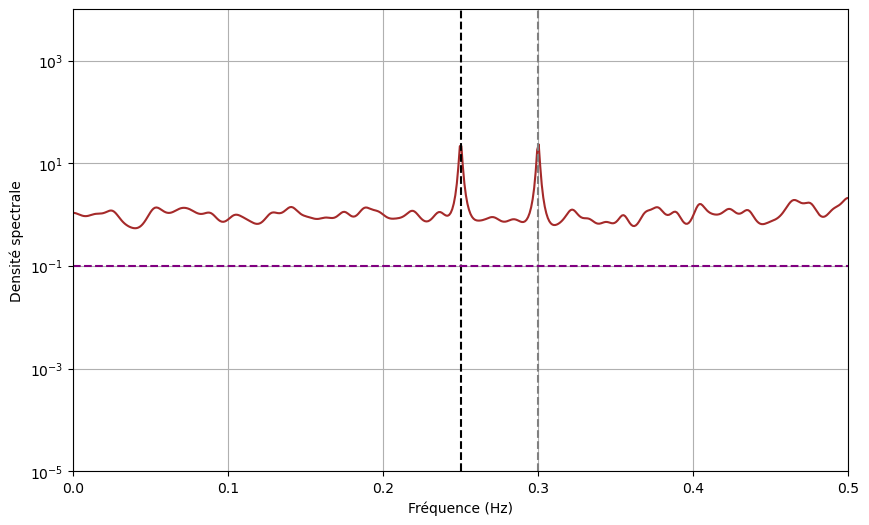

In [22]:
plt.figure(figsize=(10, 6))
plt.semilogy(capon_method(series, fs=1.0)[0],capon_method(series,fs=1.0)[1], 'brown', label="Spectre théorique")
plt.axvline(x=nu[0] / 1000, color='k', linestyle='--', label='nu1')
plt.axvline(x=nu[1] / 1000, color='gray', linestyle='--', label='nu2')
plt.axhline(y=0.1, color='purple', linestyle='--', label='Noise Std')
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale")
plt.xlim(0, 0.5)
plt.ylim(1e-5, 1e4)
plt.grid()
plt.show()

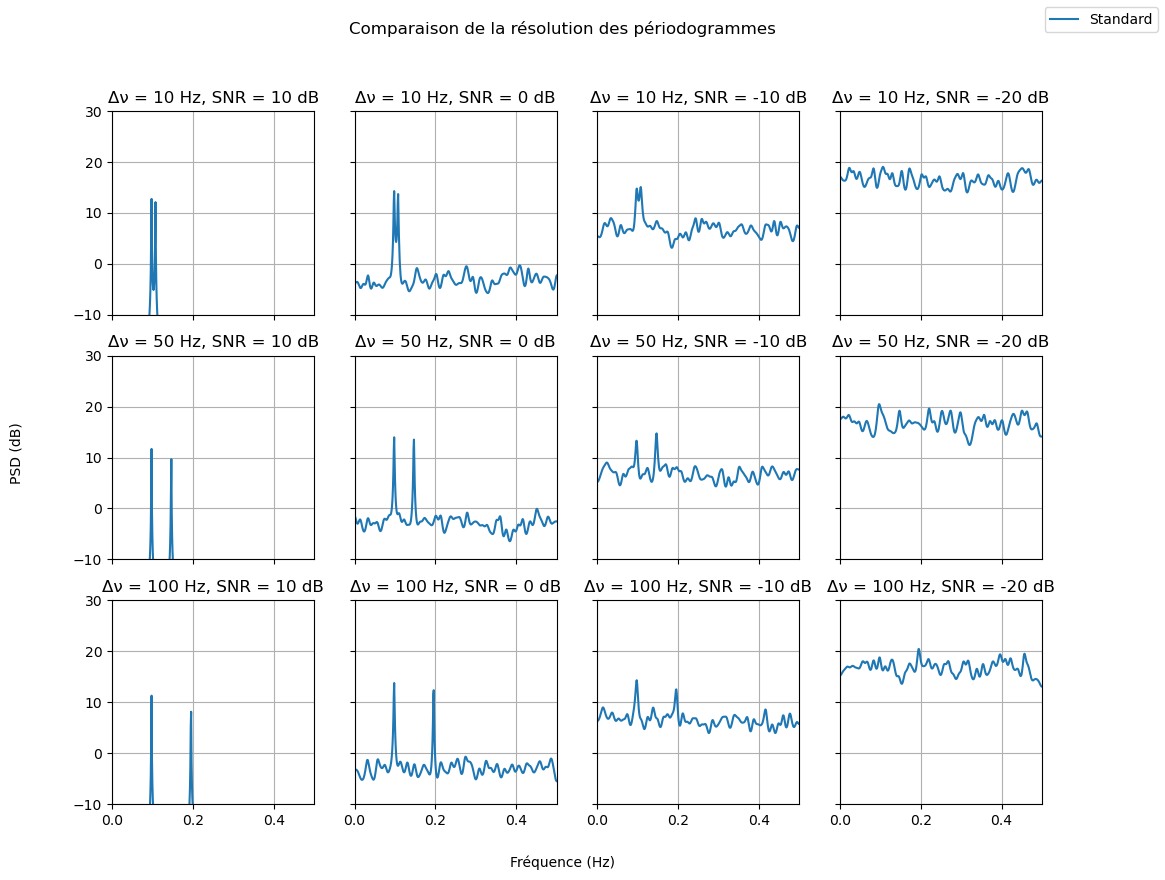

In [44]:
def computes_periodogram(signal, fs=1.0, method='standard', n_segments=None):
    if method == 'standard':
        freqs, psd = periodogram(signal, fs=fs)
    elif method in ['bartlett', 'welch']:
        if n_segments is None:
            raise ValueError("n_segments must be specified for Bartlett or Welch methods.")
        segment_length = len(signal) // n_segments
        if method == 'bartlett':
            freqs, psd = welch(signal, fs=fs, nperseg=segment_length, window='boxcar')
        else:
            freqs, psd = welch(signal, fs=fs, nperseg=segment_length)
    else:
        raise ValueError("Invalid method. Choose 'standard', 'bartlett', or 'welch'.")
    return freqs, psd


N = 1024
amplitudes = [1.0, 1.0]
phases = [0, 0]


delta_nus = [10, 50, 100]   
snr_values = [10, 0, -10, -20]   

methods = ['standard']
n_segments = 256  

fig, axs = plt.subplots(len(delta_nus), len(snr_values), figsize=(12, 9), sharex=True, sharey=True)

for i, delta_nu in enumerate(delta_nus):
    for j, snr_db in enumerate(snr_values):
        frequencies = [100, 100 + delta_nu]

        signal_power = np.mean(np.array(amplitudes)**2) / 2  
        noise_power = signal_power / (10**(snr_db / 10))     
        sigma2 = noise_power

        s = generate_sum_sine(frequencies, N, K=2, noise_std=np.sqrt(sigma2))

        axs[i, j].set_title(f"Δν = {delta_nu} Hz, SNR = {snr_db} dB")
        for method in methods:
            freqs,psd = capon_method(s, fs=1.0, num_freqs=512, order=100)
            axs[i, j].plot(freqs, 10 * np.log10(psd), label=f"{method.capitalize()}")

        for freq in frequencies:
            axs[i, j].axvline(x=freq, color='grey', linestyle='--')

        axs[i, j].set_ylim(-10, 30)
        axs[i, j].set_xlim(0, 0.5)
        axs[i, j].grid()

# Légende et labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.text(0.5, 0.04, "Fréquence (Hz)", ha='center')
fig.text(0.04, 0.5, "PSD (dB)", va='center', rotation='vertical')
plt.suptitle("Comparaison de la résolution des périodogrammes")
plt.show()

## Partie 3

<u>Question 1:</u>

In [ ]:
def generate_ARMA(coeffsAR,coeffsMA,N,noise_std) :
    p = len(coeffsAR)  # Ordre du modèle AR
    q = len(coeffsMA)  # Ordre du modèle MA
    series = np.ones(N)
    noise = np.random.normal(0, noise_std, N)
    
    for t in range(max(p, q), N):
        series[t] = sum(coeffsAR[i] * series[t - i - 1] for i in range(p)) + \
                    sum(coeffsMA[i] * noise[t - i - 1] for i in range(q)) + noise[t]
    
    return series

In [25]:
coeffsAR = [0.9]
coeffsMA = [0.5]
N = 1000

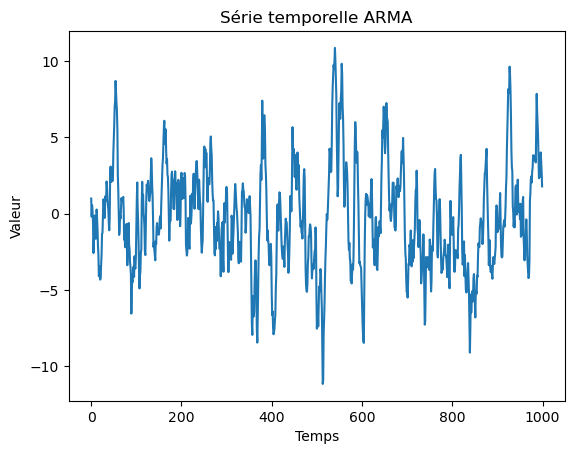

In [26]:
series = generate_ARMA(coeffsAR, coeffsMA, N, noise_std)
plt.plot(series)
plt.title("Série temporelle ARMA")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.show()

<u>Question 2:</u>

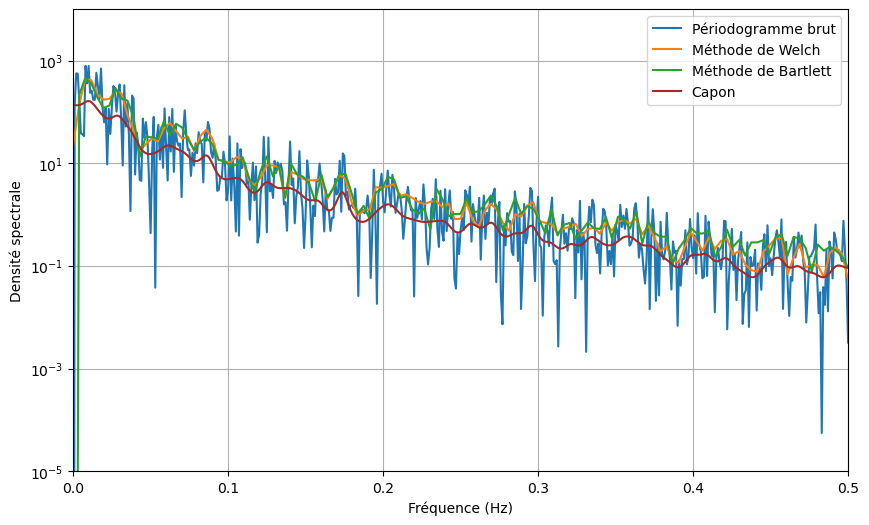

In [27]:
plt.figure(figsize=(10, 6))
plt.semilogy(abs(periodogram(series, fs=1.0)[0]), periodogram(series, fs=1.0)[1])
plt.semilogy(abs(welch(series, fs=1.0, nperseg=256)[0]), welch(series, fs=1.0, nperseg=256)[1])
plt.semilogy(abs(welch(series, fs=1.0, nperseg=256, window='boxcar')[0]), welch(series, fs=1.0, nperseg=256, window='boxcar')[1])
plt.semilogy(capon_method(series, fs=1.0)[0], capon_method(series, fs=1.0)[1], 'brown', label="Capon")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale")
plt.legend(["Périodogramme brut", "Méthode de Welch", "Méthode de Bartlett","Capon"])
plt.xlim(0, 0.5)
plt.ylim(1e-5, 1e4)
plt.grid()
plt.show()

<u>Question 3:</u>

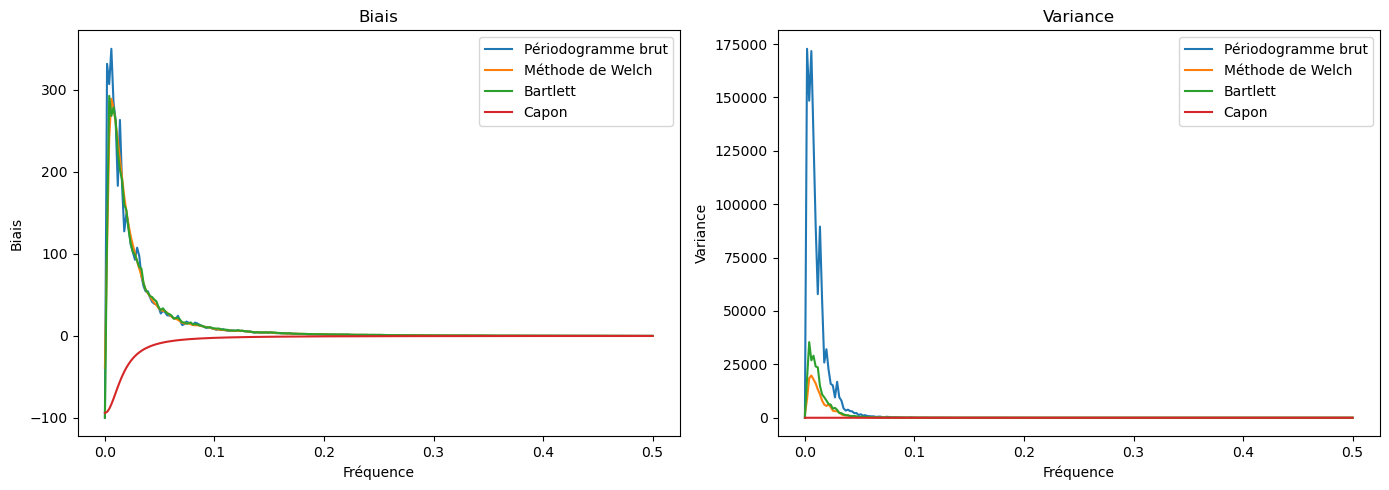

,Biais moyen,Variance moyenne
Périodogramme brut,16.930367,4331.495222
Méthode de Welch,15.528484,626.273557
Bartlett,15.952821,946.895473
Capon,5.02937,0.03448


In [37]:
import numpy as np

def capon_spectrum(x, frequencies, M=20):
    N = len(x)
    X = np.zeros((N - M, M), dtype=complex)
    for t in range(M, N):
        X[t - M, :] = x[t : t - M : -1]

    R_x = (1.0/(N - M)) * (X.conj().T @ X)
    R_inv = np.linalg.inv(R_x)

    psd_capon = np.zeros(len(frequencies))
    for i, freq in enumerate(frequencies):
        w = 2.0 * np.pi * freq
        a = np.exp(-1j * w * np.arange(M)).reshape(M, 1)
        psd_capon[i] = 1.0 / np.real(a.conj().T @ R_inv @ a)

    return psd_capon

def compare_estimators2(ar_coeff, ma_coeff=None, n_samples=1000, n_realizations=100, noise_std=1.0):
    frequencies = np.linspace(0, 0.5, 256)
    theoretical_spectrum = AR_theoretical_spectrum(ar_coeff, frequencies)
    
    raw_periodograms = np.zeros((n_realizations, len(frequencies)))
    welch_periodograms = np.zeros((n_realizations, len(frequencies)))
    bartlett_periodograms = np.zeros((n_realizations, len(frequencies)))

    capon_periodograms = None
    if ma_coeff is not None:
        capon_periodograms = np.zeros((n_realizations, len(frequencies)))

    for i in range(n_realizations):
        # Génération du signal (AR ou ARMA)
        if ma_coeff is not None:
            x = generate_ARMA(ar_coeff, ma_coeff, n_samples, noise_std)
        else:
            x = generate_AR(ar_coeff, n_samples, noise_std)

        # 1) Périodogramme brut
        f_raw, pxx_raw = periodogram(x, fs=1.0, nfft=512)
        raw_periodograms[i] = np.interp(frequencies, f_raw, pxx_raw)

        # 2) Welch
        f_welch, pxx_welch = welch(x, fs=1.0, nperseg=256, noverlap=128, nfft=512)
        welch_periodograms[i] = np.interp(frequencies, f_welch, pxx_welch)
        
        # 3) Bartlett
        n_segments = 4
        segment_len = n_samples // n_segments
        bartlett_pxx = np.zeros_like(f_raw)
        for j in range(n_segments):
            start_idx = j * segment_len
            end_idx = (j + 1) * segment_len
            segment = x[start_idx:end_idx]
            _, pxx_segment = periodogram(segment, fs=1.0, nfft=512)
            bartlett_pxx += pxx_segment
        bartlett_pxx /= n_segments
        bartlett_periodograms[i] = np.interp(frequencies, f_raw, bartlett_pxx)
        
        # 4) Capon
        if ma_coeff is not None:
            capon_pxx = capon_spectrum(x, frequencies, M=20)
            capon_periodograms[i] = capon_pxx

    estimators = {
        'Périodogramme brut': raw_periodograms,
        'Méthode de Welch': welch_periodograms,
        'Bartlett': bartlett_periodograms
    }
    
    if capon_periodograms is not None:
        estimators['Capon'] = capon_periodograms

    results = {}
    for name, data in estimators.items():
        mean_spectrum = np.mean(data, axis=0)
        bias = mean_spectrum - theoretical_spectrum
        variance = np.var(data, axis=0)
        results[name] = {'bias': bias, 'variance': variance}

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    for name, data in results.items():
        axs[0].plot(frequencies, data['bias'], label=name)
    axs[0].set_title('Biais')
    axs[0].set_xlabel('Fréquence')
    axs[0].set_ylabel('Biais')
    axs[0].legend()

    for name, data in results.items():
        axs[1].plot(frequencies, data['variance'], label=name)
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Fréquence')
    axs[1].set_ylabel('Variance')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Tableau final
    metrics = pd.DataFrame(index=estimators.keys(), columns=['Biais moyen', 'Variance moyenne'])
    for name, data in results.items():
        metrics.loc[name, 'Biais moyen'] = np.mean(np.abs(data['bias']))
        metrics.loc[name, 'Variance moyenne'] = np.mean(data['variance'])

    return metrics

compare_estimators2(ar_coeff=[0.9], ma_coeff=[0.5], n_samples=1000, n_realizations=100)

<u>Question 4:</u>

In [38]:
def Durbin_method_arma(signal, order_ar, order_ma):
    from statsmodels.tsa.arima.model import ARIMA

    # Ajuster un modèle ARMA (ARIMA sans différenciation)
    model = ARIMA(signal, order=(order_ar, 0, order_ma))
    model_fit = model.fit()

    # Extraire les coefficients AR et MA
    ar_coeffs = model_fit.arparams
    ma_coeffs = model_fit.maparams

    return ar_coeffs, ma_coeffs

In [ ]:
def ARMA_theoretical_spectrum(ar_coeff,ma_coeff, frequencies):
    p = len(ar_coeff)
    q = len(ma_coeff)
    z = np.exp(-2j * np.pi * frequencies)
    
    denominator = np.ones_like(frequencies, dtype=complex)
    for i in range(p):
        denominator -= ar_coeff[i] * z**(i+1)
    
    numerator = np.ones_like(frequencies, dtype=complex)
    for i in range(q):
        numerator += ma_coeff[i] * z**(i+1)
    
    return np.abs(numerator / denominator)**2

<u>Question 6:</u>

Coefficient AR vrai: 0.9
Coefficient AR estimé: [0.90157178]
Erreur d'estimation: [0.00157178]
MSE entre les spectres: 1.112735


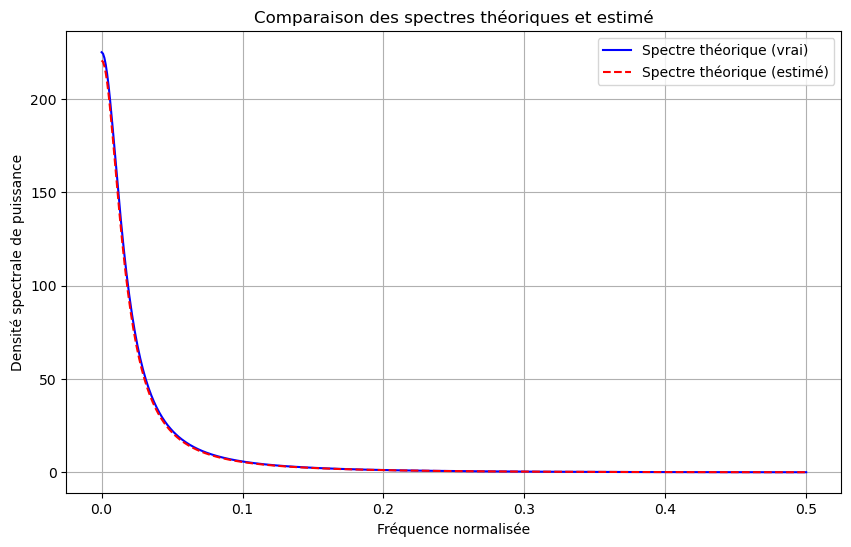

In [ ]:
true_ar_coeff = [0.9]  # Coefficient AR vrai
true_ma_coeff = [0.5]  # Coefficient MA vrai
n_samples = 1000
x = generate_ARMA(true_ar_coeff,true_ma_coeff, n_samples,noise_std)

estimated_coeffs = Durbin_method_arma(x, 1, 1)

print(f"Coefficient AR vrai: {true_coeff[0]}")
print(f"Coefficient AR estimé: {estimated_coeffs[0]}")

frequencies = np.linspace(0, 0.5, 512)
true_spectrum = ARMA_theoretical_spectrum(true_ar_coeff, true_ma_coeff, frequencies)
estimated_spectrum = ARMA_theoretical_spectrum(estimated_coeffs[0], estimated_coeffs[1],frequencies)

plt.figure(figsize=(10, 6))
plt.plot(frequencies, true_spectrum, 'b-', label='Spectre théorique (vrai)')
plt.plot(frequencies, estimated_spectrum, 'r--', label='Spectre théorique (estimé)')


plt.xlabel('Fréquence normalisée')
plt.ylabel('Densité spectrale de puissance')
plt.title('Comparaison des spectres théoriques et estimé')
plt.legend()
plt.grid(True)

error = np.abs(true_coeff[0] - estimated_coeffs[0])
print(f"Erreur d'estimation: {error}")

mse = np.mean((true_spectrum - estimated_spectrum)**2)
print(f"MSE entre les spectres: {mse:.6f}")